# Assignment 1: Computational Finance

In [2]:
import yfinance as yf
import datetime

ticker = "AAPL"
start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

data = yf.download(ticker, start = start_date, end = end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Historical Estimators

In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455077,6.391279,6.422877,493729600
2010-01-05,6.451465,6.487878,6.417459,6.458085,601904800
2010-01-06,6.348847,6.477046,6.342227,6.451467,552160000
2010-01-07,6.337109,6.379842,6.291066,6.372319,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328684,447610800


In [4]:
mean_close = data['Close'].mean()
vol = data['Close'].std()
print(mean_close, vol)

Ticker
AAPL    70.234327
dtype: float64 Ticker
AAPL    68.324972
dtype: float64


In [5]:
import numpy as np # for the np.sqrt

In [42]:
T = len(data)
print(T)

3838


In [52]:
def sigma_parkinson_estimator(_high, _low, _open, _close, T):
    return np.sqrt(
        1/(4*np.log(2))*np.sum(np.log(_high/_low)**2)
        )

In [53]:
def sigma_garman_klass_estimator(_high, _low, _open, _close, T):
    return np.sqrt(
        (1/(2*T))*np.sum(np.log(_high/_low)**2) - 
        ((2*np.log(2)-1)/T) * np.sum((np.log(_close/_open))**2)
        )

In [64]:
rollingT = 30
sigma_gk = [sigma_garman_klass_estimator(
            data.iloc[t:t+rollingT]["High"].to_numpy()[0], data.iloc[t:t+rollingT]["Low"].to_numpy()[0], data.iloc[t:t+rollingT]["Open"].to_numpy()[0], data.iloc[t:t+rollingT]["Close"].to_numpy()[0], rollingT
            ) for t in range(len(data)-rollingT)]

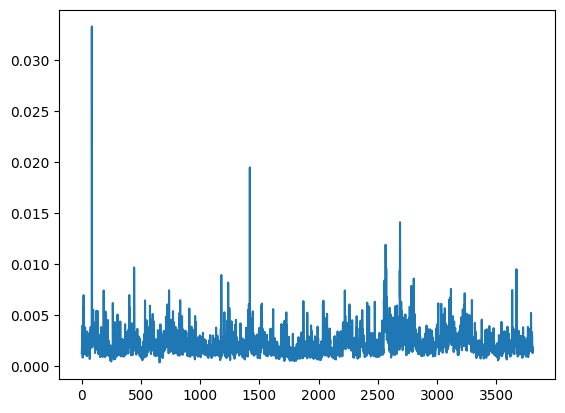

In [65]:
import matplotlib.pyplot as plt

plt.plot(sigma_gk)
plt.show()

In [66]:
rollingT = 30
sigma_p = [sigma_parkinson_estimator(
            data.iloc[t:t+rollingT]["High"].to_numpy()[0], data.iloc[t:t+rollingT]["Low"].to_numpy()[0], data.iloc[t:t+rollingT]["Open"].to_numpy()[0], data.iloc[t:t+rollingT]["Close"].to_numpy()[0], rollingT
            ) for t in range(len(data)-rollingT)]

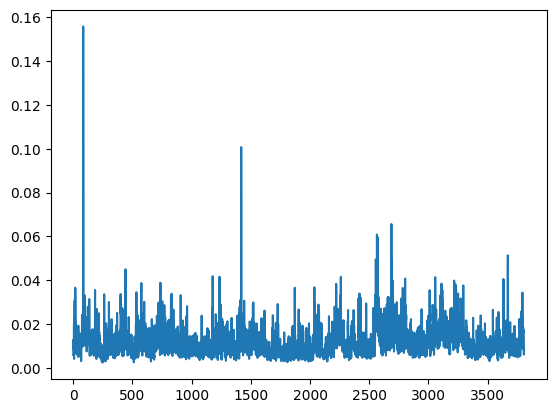

In [67]:
import matplotlib.pyplot as plt

plt.plot(sigma_p)
plt.show()

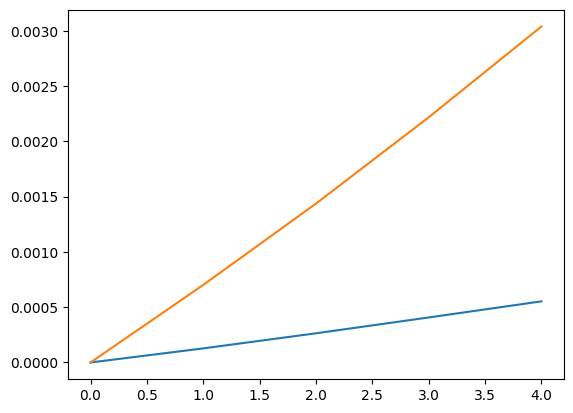

In [68]:
def volatility_signature_plot(m,rollingT):
    grid = np.linspace(0, len(data)-1, m).astype(int)
    data_m = data.iloc[grid]
    sigma_gk = [sigma_garman_klass_estimator(
            data_m.iloc[t:t+rollingT]["High"].to_numpy()[0], data_m.iloc[t:t+rollingT]["Low"].to_numpy()[0], data_m.iloc[t:t+rollingT]["Open"].to_numpy()[0], data_m.iloc[t:t+rollingT]["Close"].to_numpy()[0], rollingT
            ) for t in range(len(data_m)-rollingT)]
    sigma_p = [sigma_parkinson_estimator(
            data_m.iloc[t:t+rollingT]["High"].to_numpy()[0], data_m.iloc[t:t+rollingT]["Low"].to_numpy()[0], data_m.iloc[t:t+rollingT]["Open"].to_numpy()[0], data_m.iloc[t:t+rollingT]["Close"].to_numpy()[0], rollingT
            ) for t in range(len(data_m)-rollingT)]
    GK = np.sum(sigma_gk)/T
    P = np.sum(sigma_p)/T
    return GK, P

GK_signature = [volatility_signature_plot(i,rollingT)[0] for i in np.linspace(0, 1000, 5).astype(int)]
P_signature = [volatility_signature_plot(i,rollingT)[1] for i in np.linspace(0, 1000, 5).astype(int)]


plt.plot(GK_signature)
plt.plot(P_signature)
plt.show()